In [6]:
import pandas as pd

In [7]:
data = pd.read_csv('dataset.csv')
synopses = {id: synopsis for id, synopsis in zip(data['id'], data['synopsis'])}
NUM_DATAPOINTS_TRAIN = 100
NUM_DATAPOINTS_VAL = 50

In [8]:
def parse_data(path, n):
    data = pd.read_csv(path)
    # Remove scores of 1, as we don't need to train these
    for index, row in data.iterrows():
        if row['score'] == 1:
            data.drop(index, inplace=True)
    data = data[:n]
    pairs = [[synopses[id1], synopses[id2]] for id1, id2 in zip(data['id1'], data['id2'])]
    labels = data['binary_label']
    return pairs, labels  

In [9]:
train_pairs, train_labels = parse_data('user_based_correlations_train.csv', NUM_DATAPOINTS_TRAIN)
val_pairs, val_labels = parse_data('user_based_correlations_val.csv', NUM_DATAPOINTS_VAL)

In [10]:
from fidelity_model import FidelityModel, fidelity_pqc_gen
train_circuits = [fidelity_pqc_gen(sentence_1, sentence_2) for sentence_1, sentence_2 in train_pairs]
val_circuits = [fidelity_pqc_gen(sentence_1, sentence_2) for sentence_1, sentence_2 in val_pairs]

In [11]:
from lambeq import Dataset
train_dataset = Dataset(
        train_circuits,
        train_labels,
        batch_size=30)
val_dataset = Dataset(
        val_circuits,
        val_labels,
        batch_size=30)

In [12]:
from lambeq import QuantumTrainer, SPSAOptimizer
import numpy as np
EPOCHS = 120
SEED = 2
A = 0.1
C = 0.06
def loss(predictions, labels):
    return np.mean(np.abs(predictions-labels)**2)

In [13]:
model = FidelityModel.from_diagrams(train_circuits+val_circuits, use_jit=True)
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': A, 'c': C, 'A':0.01*EPOCHS},
    seed=SEED
)

model.save('my_checkpoint.lt')

print(f"===TRAINING===")
for i in range(5):
    model.load('my_checkpoint.lt')  # Load from 'empty' training checkpoint (means jitted circuits are saved but model is fresh for new round of training)
    trainer.fit(train_dataset, val_dataset, log_interval=20)

===TRAINING===


Epoch 20:   train/loss: 0.0391   valid/loss: 0.2051   train/time: 2m37s   valid/time: 0.96s
Epoch 40:   train/loss: 0.1814   valid/loss: 0.1942   train/time: 7.82s   valid/time: 0.96s
Epoch 60:   train/loss: 0.1331   valid/loss: 0.2327   train/time: 7.74s   valid/time: 0.95s
Epoch 80:   train/loss: 0.1079   valid/loss: 0.2804   train/time: 7.79s   valid/time: 0.96s
Epoch 100:  train/loss: 0.1192   valid/loss: 0.2966   train/time: 7.84s   valid/time: 0.97s
Epoch 120:  train/loss: 0.0524   valid/loss: 0.2820   train/time: 7.78s   valid/time: 0.96s

Training completed!
train/time: 3m16s   train/time_per_epoch: 1.63s   train/time_per_step: 0.41s   valid/time: 1m23s   valid/time_per_eval: 0.35s
Epoch 20:   train/loss: 0.3783   valid/loss: 0.2003   train/time: 7.93s   valid/time: 0.95s
Epoch 40:   train/loss: 0.3735   valid/loss: 0.2193   train/time: 7.96s   valid/time: 0.93s
Epoch 60:   train/loss: 0.1593   valid/loss: 0.2072   train/time: 7.84s   valid/time: 0.96s
Epoch 80:   train/loss: 0

In [14]:
train_costs = np.empty((5, EPOCHS))
val_costs = np.empty((5, EPOCHS))
for i in range(5):
    train_costs[i] = trainer.train_epoch_costs[i*EPOCHS:(i+1)*EPOCHS]
    val_costs[i] = trainer.val_costs[i*EPOCHS:(i+1)*EPOCHS]

In [15]:
train_costs_mean = np.mean(train_costs, axis=0)
val_costs_mean = np.mean(val_costs, axis=0)
np.savetxt(f"train_costs.csv", train_costs_mean, delimiter=',')
np.savetxt(f"val_costs.csv", val_costs_mean, delimiter=',')

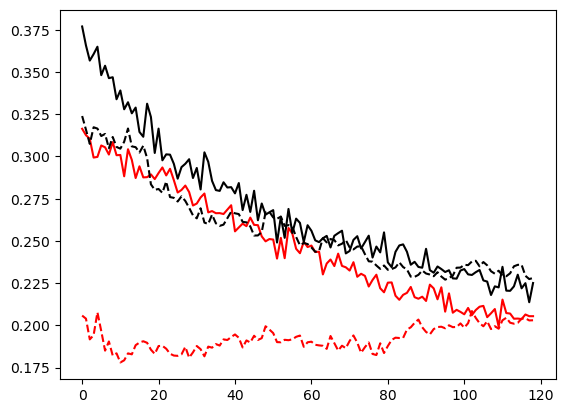

In [16]:
import matplotlib.pyplot as plt
train_costs_avg = pd.read_csv("train_costs.csv")
val_costs_avg =  pd.read_csv("val_costs.csv")
plt.plot(train_costs_avg, 'r-', label="train")
plt.plot(val_costs_avg, 'r--', label="val")
plt.plot( pd.read_csv("train_costs_a-0.1.csv"), 'k-', label="train")
plt.plot( pd.read_csv("val_costs_a-0.1.csv"), 'k--', label="val")
plt.show()